In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

tf.logging.set_verbosity(tf.logging.INFO)

log_dir = 'tmp/loopy-nn/board/loop004' # Tensorboard log dir
save_dir = 'tmp/loopy-nn/checkpoints/loop004' # Checkpoint saver dir
plt_dir = 'tmp/loopy-nn/plots/loop004' # Checkpoint saver dir

for d in log_dir, save_dir, plt_dir:
    if not os.path.exists(d):
        os.makedirs(d)

# MNIST data set
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


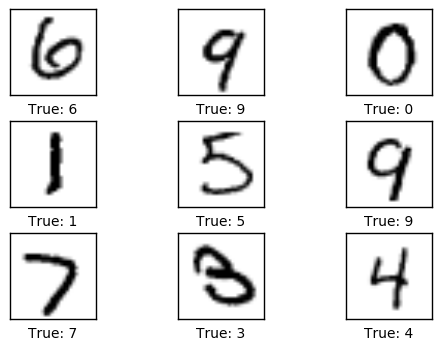

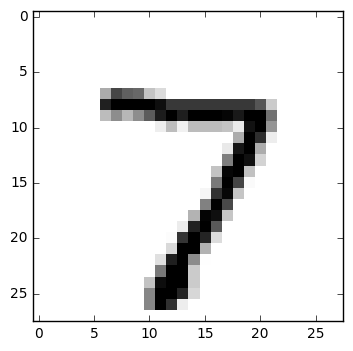

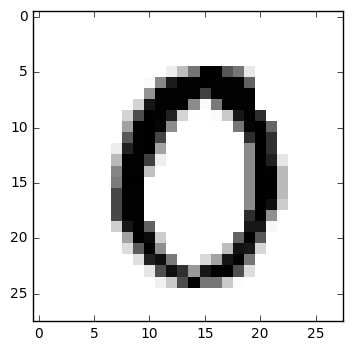

Accuracy on Test-Set: 10.2% (1024 / 10000)
Mean: -0.00306, Stdev: 0.04537


//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/pyplot.py:1191: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  axarr = np.empty(nplots, dtype=object)


TypeError: can't multiply sequence by non-int of type 'float'

In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

tf.logging.set_verbosity(tf.logging.INFO)

log_dir = 'tmp/loopy-nn/board/loop004' # Tensorboard log dir
save_dir = 'tmp/loopy-nn/checkpoints/loop004' # Checkpoint saver dir
plt_dir = 'tmp/loopy-nn/plots/loop004' # Checkpoint saver dir

for d in log_dir, save_dir, plt_dir:
    if not os.path.exists(d):
        os.makedirs(d)

# MNIST data set
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

require_improvement = 1000 # Stop optimization if no improvement found in n iterations
train_batch_size = 64
learning_rate = 1e-4

# Convolutional Layer 1 Filter size (number of pixels) 5 equals 5 x 5 square
filter_size1 = 5

# Convolutional Loop Layer 1
loop_filter_shape = [16, 8, 1] # number of filters per layer 
unrolls = 1 # Loops in network

# Convolutional Layer 1 for baseline (disabled when running loop)
run_baseline = True # Set to True when running baseline algorithm without loops
num_filters1 = 16
use_pooling_1 = True

# Convolutional Layer 2
filter_size2 = 5
num_filters2 = 36
use_pooling_2 = True

# Fully-connected layer size
fc_size = 128 

# Image parameters
img_size = 28 # MNIST images are 28 x 28 pixels
img_size_flat = img_size * img_size # flatten images into array
img_shape = (img_size, img_size) # Tuple for reshaping images from flattened arrays
num_channels = 1 # color channels (1 = grayscale, 3 = rgb)
num_classes = 10 # Number of classes (MNIST has 10 digits to classify)

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

# Many of the functions here are modified or taken directly from Magnus Petersson's excellent series on Tensorflow tutorials. Please see his repositories at: https://githhub.com/Hvass-Labs/TensorFlow-Tutorials
def new_weights(i, lp, shape):
    if lp == -1:
        name = 'weights_'
    else:
        name = 'weights_' + str(lp) + '_' + str(i)
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), name=name)
    
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def get_weights_variable(layer_name, tensor_name):
    
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable(tensor_name)

    return variable

# Standard convolutional layer constructor
def new_conv_layer(input,              # Layer input
                   num_input_channels, # Number of channels in previous layer
                   filter_size,        # Width and height of each filter
                   num_filters,        # Number of filters
                   use_pooling=True):  # Use max pooling boolean

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(i=-1, lp=-1, shape=shape)
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME',
                         name='layer_conv2')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1], # [img number, kernel size x-axis, kernel size y-axis, input channel]
                               strides=[1, 2, 2, 1], # [img number, stride x-axis, stride y-axis, input channel]
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

# Function to build layered looping network
def loop_layered_network(input,         # Layer input for loop
                    num_input_channels, # Number of channels in previous layer
                    filter_size,        # Width and height of each filter
                    num_filters,        # Number of filters
                    loop_filter_shape,  # Number of filters per layer default = [16, 8, 1]
                    unrolls,            # Num loops (i.e. how many times the conv network will get unrolled)
                    use_pooling=True):  # Use max pooling boolean
    
    loops = unrolls
    begin = True # If first unroll then begin = True
    lp = 0

    biases = new_biases(length=num_filters)
    while loops:
        for i in range(len(loop_filter_shape)):
            if begin:
                begin = False
                layer = input
                layer, weights = loop_first_layer(layer, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp)
            elif i == 0:
                layer, weights = loop_begin_loop(layer, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp)   
            elif i < (len(loop_filter_shape)-1):
                layer, weights = loop_mid_layer(layer, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp)
            elif loops == 1:
                layer, weights = loop_exit(layer, num_input_channels, filter_size, num_filters, loop_filter_shape, use_pooling, i, lp)
            else:
                layer, weights = loop_last_layer(layer, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp)
        
        loops -= 1
        lp += 1
    layer += biases
    layer = tf.nn.relu(layer)
    
    return layer, weights
    
# Function for constructing convolutional loop layers 
def const_conv_layer(layer, weights, use_pooling):
    layer = tf.nn.conv2d(input=layer,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME',
                         name='layer_conv1')

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1], # [img number, kernel size x-axis, kernel size y-axis, input channel]
                               strides=[1, 2, 2, 1], # [img number, stride x-axis, stride y-axis, input channel]
                               padding='SAME',
                               name='layer_conv1')

    return layer, weights

# Loop layer constructors
def loop_first_layer(input, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp):
    layer = input
    shape = [filter_size, filter_size, num_input_channels, loop_filter_shape[0]]
    weights = new_weights(i, lp, shape=shape) # Initialize weights for loop

    return const_conv_layer(layer, weights, use_pooling=False)
    
def loop_begin_loop(input, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp):
    layer = input
    shape = [filter_size, filter_size, loop_filter_shape[-1], loop_filter_shape[0]]
    weights = new_weights(i, lp, shape=shape) # Initialize weights for loop
    
    return const_conv_layer(layer, weights, use_pooling=False)

def loop_mid_layer(input, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp):
    layer = input
    shape = [filter_size, filter_size, loop_filter_shape[i-1], loop_filter_shape[i]]
    weights = new_weights(i, lp, shape=shape) # Initialize weights for loop

    return const_conv_layer(layer, weights, use_pooling=False)

def loop_last_layer(input, num_input_channels, filter_size, num_filters, loop_filter_shape, i, lp):
    layer = input
    shape = [filter_size, filter_size, loop_filter_shape[-2], loop_filter_shape[-1]]
    weights = new_weights(i, lp, shape=shape) # Initialize weights for loop

    return const_conv_layer(layer, weights, use_pooling=False)

def loop_exit(input, num_input_channels, filter_size, num_filters, loop_filter_shape, use_pooling, i, lp):
    layer = input
    shape = [filter_size, filter_size, loop_filter_shape[-2], loop_filter_shape[-1]]
    weights = new_weights(i, lp, shape=shape) # Initialize weights for loop

    return const_conv_layer(layer, weights, use_pooling)

# Flatten layers before entering fully connected layers
def flatten_layer(layer):
    layer_shape = layer.get_shape() # [num_images, img_height, img_width, num_channels]
    num_features = layer_shape[1:4].num_elements() # (img_height * img_width * num_channels)
    layer_flat = tf.reshape(layer, [-1, num_features]) # [num_images, num_features]

    return layer_flat, num_features

# Fully-connected layer constructor
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(i=-1, lp=-1, shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# When running comparative tests, swap standard convolutional network for looping network
if run_baseline:
    layer_conv1, weights_conv1 = \
        new_conv_layer(input=x_image,
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=use_pooling_1)
else:
    layer_conv1, weights_conv1 = \
        loop_layered_network(input=x_image,
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       loop_filter_shape=loop_filter_shape,
                       unrolls=unrolls,
                       use_pooling=use_pooling_1)
                       
# Build network after looping layer
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=use_pooling_2)

layer_flat, num_features = flatten_layer(layer_conv2)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

best_validation_accuracy = 0.0
last_improvement = 0
total_iterations = 0
def optimize_loopy(num_iterations):
    global total_iterations
    global best_validation_accuracy
    global last_improvement

    start_time = time.time()

    for i in range(num_iterations):
        total_iterations += 1
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        summary, optimize = session.run([summary_op, optimizer], feed_dict=feed_dict_train)
        summary_writer_train.add_summary(summary, i)

        # Print status every 100 iterations and after last iteration.
        if (total_iterations % 100 == 0) or (i == (num_iterations - 1)):

            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation, _ = validation_accuracy()

            # If validation accuracy is an improvement over best-known.
            if acc_validation > best_validation_accuracy:
                best_validation_accuracy = acc_validation
                last_improvement = total_iterations

                saver.save(sess=session, save_path=save_path)

                improved_str = '*'
            else:
                improved_str = ''
            
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3}"
            print(msg.format(i + 1, acc_train, acc_validation, improved_str))

        # If no improvement found in the required number of iterations.
        if total_iterations - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")
            break

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


    
######################################################################
#                     Plotting Functions
######################################################################

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
                
def plot_confusion_matrix(cls_pred, iter_num):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    #plt.title('Confusion Matrix at iter: ' + str(iter_num))
    plt.text(0.5, 0, 'Iter: ' + str(iter_num), verticalalignment='bottom')
    file_name = plt_dir + '/Confusion_Matrix_iter_' + str(iter_num) + '.png'
    plt.show()
    plt.savefig(file_name, format='png', bbox_inches='tight')
    
    
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred
    
def predict_cls_test():
    return predict_cls(images = data.test.images,
                       labels = data.test.labels,
                       cls_true = data.test.cls)
                       
def predict_cls_validation():
    return predict_cls(images = data.validation.images,
                       labels = data.validation.labels,
                       cls_true = data.validation.cls)
                       
def cls_accuracy(correct):
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(correct)

    return acc, correct_sum
    
def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    # The function returns two values but we only need the first.
    correct, _ = predict_cls_validation()
    
    # Calculate the classification accuracy and return it.
    return cls_accuracy(correct)

def validation_accuracy_summary():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    # The function returns two values but we only need the first.
    correct, predictions = predict_cls_validation()
    
    # Calculate the classification accuracy and return it.
    return correct
    
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()

    # Classification accuracy and the number of correct classifications.
    acc, num_correct = cls_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred, iter_num=total_iterations)
        
def plot_conv_weights(weights, input_channel=0, iter_num=0, layer_name='not defined'):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print mean and standard deviation.
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    if num_filters > 1:
        
        # Number of grids to plot.
        # Rounded-up, square-root of the number of filters.
        num_grids = math.ceil(math.sqrt(num_filters))
        
        # Create figure with a grid of sub-plots.
        fig, axes = plt.subplots(num_grids, num_grids)
    
        # Plot all the filter-weights.
        for i, ax in enumerate(axes.flat):
            # Only plot the valid filter-weights.
            if i<num_filters:
                # Get the weights for the i'th filter of the input channel.
                # The format of this 4-dim tensor is determined by the
                # TensorFlow API. See Tutorial #02 for more details.
                img = w[:, :, input_channel, i]
    
                # Plot image.
                ax.imshow(img, vmin=w_min, vmax=w_max,
                          interpolation='nearest', cmap='seismic')
            
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    
    else:
        img = w[:, :, input_channel, 0]
        # Plot image.
        plt.imshow(img, vmin=w_min, vmax=w_max,
                  interpolation='nearest', cmap='seismic')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    #plt.title('Weights for ' + layer_name + ' at iter: ' + str(iter_num))
    plt.text(0.5, 0, 'Weights for ' + layer_name + ' at iter: ' + str(iter_num), verticalalignment='bottom')

    file_name = plt_dir + '/Weights_iter_' + str(iter_num) + '_layer_' + str(layer_name) + '.png'
    print(file_name)
    plt.show()
    plt.savefig(file_name, format='png', bbox_inches='tight')

# Split the test-set into smaller batches of this size.
#test_batch_size = 256
    
def plot_conv_layer(layer, image, iter_num, layer_name):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    if num_filters > 1:
        # Number of grids to plot.
        # Rounded-up, square-root of the number of filters.
        num_grids = math.ceil(math.sqrt(num_filters))
        
        # Create figure with a grid of sub-plots.
        fig, axes = plt.subplots(num_grids, num_grids)
    
        # Plot the output images of all the filters.
        for i, ax in enumerate(axes.flat):
            # Only plot the images for valid filters.
            if i<num_filters:
                # Get the output image of using the i'th filter.
                # See new_conv_layer() for details on the format
                # of this 4-dim tensor.
                img = values[0, :, :, i]
    
                # Plot image.
                ax.imshow(img, interpolation='nearest', cmap='binary')
            
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        
    else:
        img = values[0, :, :, 0]
        # Plot image.
        plt.imshow(img, # vmin=w_min, vmax=w_max,
                  interpolation='nearest', cmap='binary')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    #plt.title('Layer ' + layer_name + ' at iter: ' + str(iter_num))
    plt.text(0.5, 0, 'Layer ' + layer_name + ' at iter: ' + str(iter_num), verticalalignment='bottom')
    file_name = plt_dir + '/Layer_iter_' + str(iter_num) + '_layer_' + str(layer_name) + '.png'
    plt.show()
    plt.savefig(file_name, format='png', bbox_inches='tight')

def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()
        
######################################################################
#                     Loss and Optimization
######################################################################


y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
save_path = save_dir + 'best_validation'


######################################################################
#                     Session
######################################################################

session = tf.Session()
session.run(tf.initialize_all_variables())

# TensorBoard Summary Writer
accuracy_summary = tf.scalar_summary('Training Accuracy', accuracy)
loss_summary = tf.scalar_summary('Training Loss', cost)
summary_op = tf.merge_all_summaries()
summary_writer_train = tf.train.SummaryWriter(log_dir + '/train', session.graph)

data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

images = data.test.images[11:20] # View sample images from the test-set.
cls_true = data.test.cls[11:20] # True classes for sample images
plot_images(images=images, cls_true=cls_true) # Plot samples

image1 = data.test.images[0] 
plot_image(image1)
image2 = data.test.images[13]
plot_image(image2)

print_test_accuracy()

plot_conv_weights(weights=weights_conv1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_weights(weights=weights_conv2, iter_num=total_iterations, layer_name='Conv_2')

optimize_loopy(num_iterations=1)
print_test_accuracy()
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)
plot_conv_weights(weights=weights_conv1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image2, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv2, image=image1, iter_num=total_iterations, layer_name='Conv_2')
plot_conv_layer(layer=layer_conv2, image=image2, iter_num=total_iterations, layer_name='Conv_2')

optimize_loopy(num_iterations=99)
print_test_accuracy()
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)
plot_conv_weights(weights=weights_conv1, iter_num=total_iterations, layer_name='Conv_1')

plot_conv_layer(layer=layer_conv1, image=image1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image2, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv2, image=image1, iter_num=total_iterations, layer_name='Conv_2')
plot_conv_layer(layer=layer_conv2, image=image2, iter_num=total_iterations, layer_name='Conv_2')

optimize_loopy(num_iterations=900)
print_test_accuracy()
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)
plot_conv_weights(weights=weights_conv1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image2, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv2, image=image1, iter_num=total_iterations, layer_name='Conv_2')
plot_conv_layer(layer=layer_conv2, image=image2, iter_num=total_iterations, layer_name='Conv_2')

optimize_loopy(num_iterations=9000)
print_test_accuracy()
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)
plot_conv_weights(weights=weights_conv1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image1, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv1, image=image2, iter_num=total_iterations, layer_name='Conv_1')
plot_conv_layer(layer=layer_conv2, image=image1, iter_num=total_iterations, layer_name='Conv_2')
plot_conv_layer(layer=layer_conv2, image=image2, iter_num=total_iterations, layer_name='Conv_2')

session.close()

